In [56]:
import os
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# Opting to display warnings for better understanding of potential issues
warnings.filterwarnings('default')

sns.set_theme()

## NIH Chest X-ray Dataset Exploratory Data Analysis

This exploratory data analysis (EDA) delves into the NIH Chest X-ray Dataset, 
a collection of 112,120 X-ray images with disease labels obtained from 30,805 unique patients.

### Dataset Source

Processing (NLP) to extract disease classifications from radiological reports. While the labels are estimated to be over 90% accurate, they are intended for weakly-supervised learning and classification tasks.

**Data Limitations:**  It's important to acknowledge that as of January 2022, a team of medical professionals collaborated to provide more accurate labels. These updated labels can be found in the NIH Additional Labels within the Cloud Healthcare API documentation. However, this EDA will utilize the original labels from the Kaggle dataset. As part of the Capstone project, we will make an effort to obtain an opensource copy of the dataset with the NIH Additional labels. 

# 1. Data Loading and Initial Exploration

### 1.1 Loading the Dataset

The dataset is loaded into a Pandas DataFrame for efficient manipulation and analysis.

In [57]:
df = pd.read_csv("./Data_Entry_2017.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [58]:
# Addressing potential age entry errors by removing records with ages above 120 years.
df = df[df['Patient Age'] <= 120] 
df.head(5)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### 1.2 Dataset Overview and Descriptive Statistics

Examining the basic structure of the dataset, including the number of rows, unique  images, and unique patients.

In [61]:
print("Number of Rows:", len(df))
print("Number of Unique Images:", df["Image Index"].nunique())
print("Number of Unique Patients:", df["Patient ID"].nunique())

# Utilizing `df.describe()` to generate descriptive statistics for numerical columns.
df.describe()

Number of Rows: 112104
Number of Unique Images: 112104
Number of Unique Patients: 30802


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


**Observations:**

* The dataset standardizes all images to 1024 x 1024 pixels, but retains the original   image dimensions, which vary across images.
* The maximum 'Follow-up #' is 183, indicating a patient with a substantial number of 
  images. This requires further investigation.

### 1.3 Handling Missing Data

Checking for missing values within the DataFrame using `df.info()`.

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112104 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112104 non-null  object 
 1   Finding Labels               112104 non-null  object 
 2   Follow-up #                  112104 non-null  int64  
 3   Patient ID                   112104 non-null  int64  
 4   Patient Age                  112104 non-null  int64  
 5   Patient Gender               112104 non-null  object 
 6   View Position                112104 non-null  object 
 7   OriginalImage[Width          112104 non-null  int64  
 8   Height]                      112104 non-null  int64  
 9   OriginalImagePixelSpacing[x  112104 non-null  float64
 10  y]                           112104 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 11.1+ MB


In [64]:
# Removing the 'Unnamed: 11' column as it contains no non-null values.
df.drop("Unnamed: 11", axis=1, inplace=True)

## 2.  In-depth Variable Exploration

This section provides a comprehensive examination of each variable in the dataset.

### 2.1 Image Index

 The 'Image Index' holds valuable information encoded in the file names (e.g., `00000001_000.png`). The number preceding the underscore corresponds to the 'Patient ID',  while the number after represents the image number for that patient.

In [65]:
print(df["Image Index"][0:5])

0    00000001_000.png
1    00000001_001.png
2    00000001_002.png
3    00000002_000.png
4    00000003_000.png
Name: Image Index, dtype: object


**Observation:**

* All images are stored in PNG format, which offers higher quality but requires more storage space compared to JPEG. 
* Total download was 45 GiB uncompressed. This should be considered during model development. 
* Due to large number of files processing time will need to be considered

### 2.2 Finding Labels (Target Variable)

The 'Finding Labels' column represents the diagnoses assigned by a radiologist and serves as the target variable for our classification model.

**Key Characteristics:**

* **Multi-label Classification:**  Images can have "No Finding" or one or more of 14 disease classes (Atelectasis, Consolidation, Infiltration, etc.).
* **Label Combinations:**  There are numerous unique combinations of labels,  requiring careful handling during model training.

* **Data Cleaning:** To ensure consistency, labels are split, sorted  alphabetically, and rejoined, reducing the number of unique combinations.

In [67]:
print("Unique Combinations Before Transformation:", df["Finding Labels"].nunique())

df["Finding Labels"] = df["Finding Labels"].str.split("|").apply(
    lambda x: sorted(x)).str.join("|")

print("Unique Combinations After Transformation:", df["Finding Labels"].nunique())

# **Visualizing Label Distribution:**

def visualize_label_distribution(df):
    """
    Generates visualizations to understand the distribution of labels.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    
    # Splitting labels and counting occurrences
    label_counts = df.assign(
        var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
    label_counts = label_counts.reset_index(drop=True).to_frame()
    label_counts.columns = ["label"]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.tick_params(axis='x', rotation=45)
    sns.histplot(
        label_counts, x="label", discrete=True, ax=ax, shrink=.9).set_title(
            "Distribution of Individual Labels")
    ax.bar_label(ax.containers[0])
    plt.ylim(0, 70000)
    plt.show()

    # Analyzing the number of labels per image
    labels_per_image = df["Finding Labels"].str.count(r'\|') + 1
    labels_per_image = labels_per_image.reset_index(drop=True).to_frame()
    labels_per_image.columns = ["Label Count"]

    fig, ax = plt.subplots(figsize=(15, 5))
    sns.histplot(
        labels_per_image,
        x="Label Count",
        discrete=True,
        ax=ax,
        shrink=.9).set_title("Number of Labels per Image")
    ax.bar_label(ax.containers[0])
    plt.ylim(0, 100000)
    plt.show()

visualize_label_distribution(df)

**Observations:**

* "No Finding" is the most frequent label.
* Effusion, Infiltration, and Atelectasis are among the most common diseases.
* Hernia is the least common finding.
* A significant number of images have multiple labels, with some exceeding four labels. This might require special attention during model training.

### 2.3 Follow-up Number

'Follow-up #' indicates the number of times a patient has been examined.

**Visualization:**

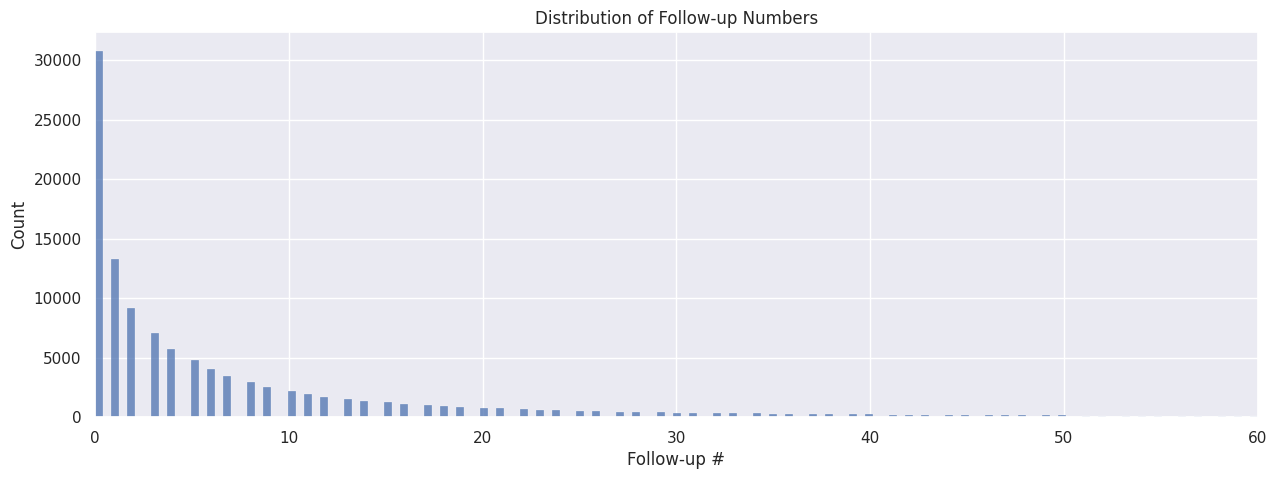

In [70]:
def visualize_follow_up(df):
    """
    Visualizes the distribution of follow-up numbers.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.histplot(data=df, x="Follow-up #", ax=ax).set_title(
        'Distribution of Follow-up Numbers')
    plt.xlim(0, 60)
    plt.show()

visualize_follow_up(df)

**Observation:**  

* The distribution is heavily right-skewed, with most patients  having fewer than 10 images. However, outliers with very high follow-up numbers exist.

### 2.4 Patient ID

While 'Patient ID' primarily serves as a unique identifier, it might be useful in conjunction with other variables to extract further insights.

### 2.5 Patient Age

**Visualization:**

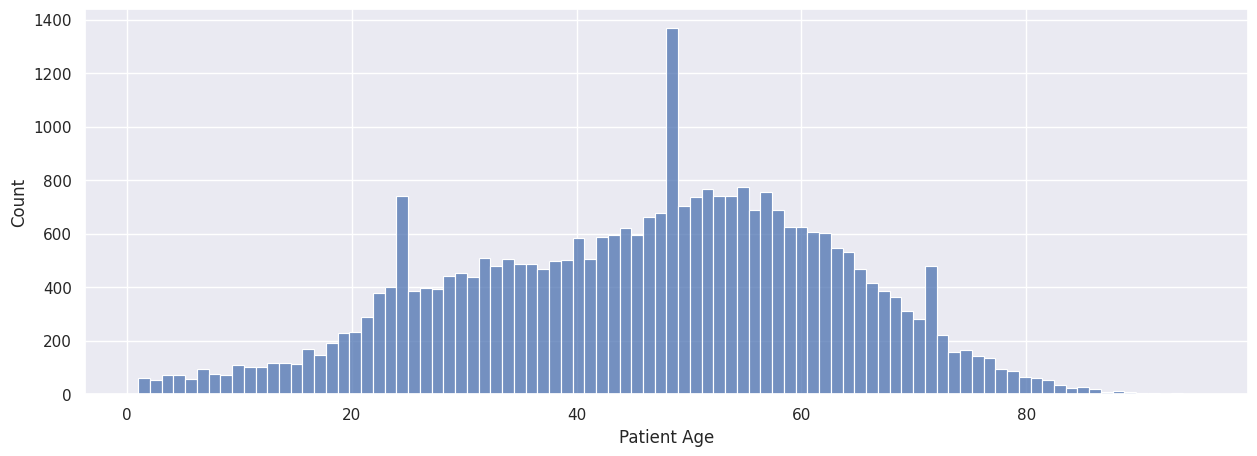

In [72]:
def visualize_patient_age(df):
    """
    Visualizes the distribution of patient ages.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(15, 5))
    sns.histplot(test, x="Patient Age", ax=ax, bins=90)
    plt.show()

visualize_patient_age(df)

**Observations:**

* The majority of patients fall within the 30-70 age range.
* There are noticeable peaks in specific age groups, which might be related to  data collection methods or routine health checkups at those ages.

### 2.6 Patient Gender

This variable indicates the gender of the patient (Male or Female).

**Visualization:**

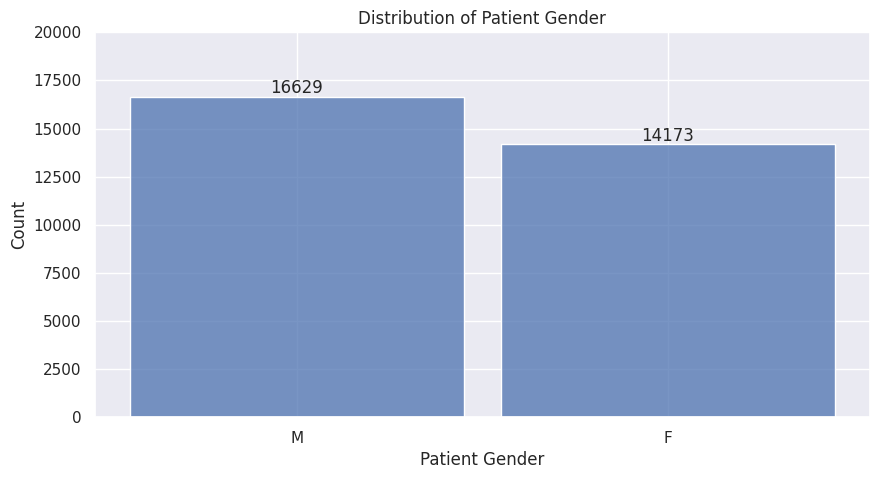

In [75]:
def visualize_patient_gender(df):
    """
    Visualizes the distribution of patient genders.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    # Removing duplicate patients for accurate counts
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        test,
        x="Patient Gender",
        discrete=True,
        ax=ax,
        shrink=.9).set_title("Distribution of Patient Gender")
    ax.bar_label(ax.containers[0])
    plt.ylim(0, 20000)
    plt.show()

visualize_patient_gender(df)

# **Observation:**  There's a slight imbalance with a higher number of images from 
# male patients.

### 2.7 View Position

This variable specifies the perspective from which the X-ray image was taken:

* PA: Posterior to Anterior (from the back)
* AP: Anterior to Posterior (from the front)

**Visualization:**

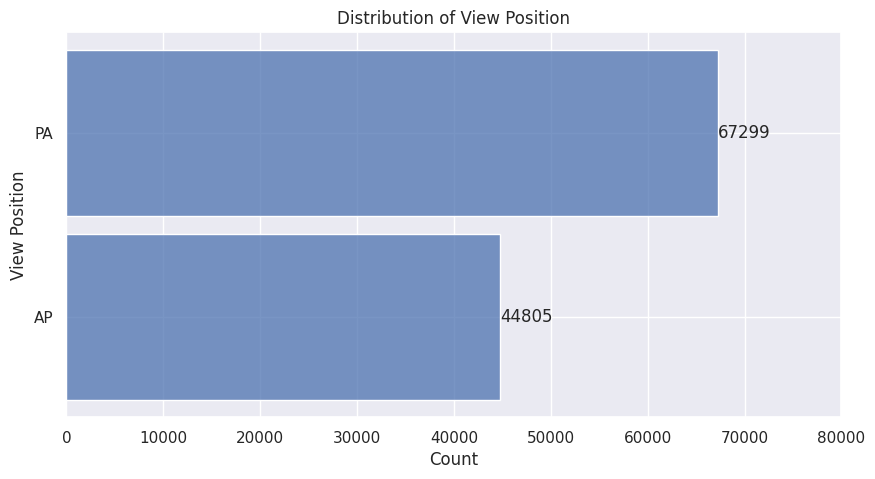

In [78]:
def visualize_view_position(df):
    """
    Visualizes the distribution of view positions.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title(
            "Distribution of View Position")
    ax.bar_label(ax.containers[0])
    plt.xlim(0, 80000)
    plt.show()

visualize_view_position(df)

**Observation:** 

* Majority of the images images are taken from the PA position.

### 2.8 Original Image Dimensions and Pixel Spacing

The columns 'OriginalImage[Width', 'Height]', and 'OriginalImagePixelSpacing[x y]' provide information about the original image dimensions and pixel spacing. For this EDA, these columns will be excluded as the focus is on the provided labels and patient demographics.

**Removing less relevant columns:**

In [82]:
cols_of_interest = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position"
]

df = df[cols_of_interest]
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


## 3. Investigating Relationships between Variables

This section explores potential relationships between variables to gain a deeper understanding of the dataset and inform model building decisions.


### 3.1 Age and Gender

**Visualization:**

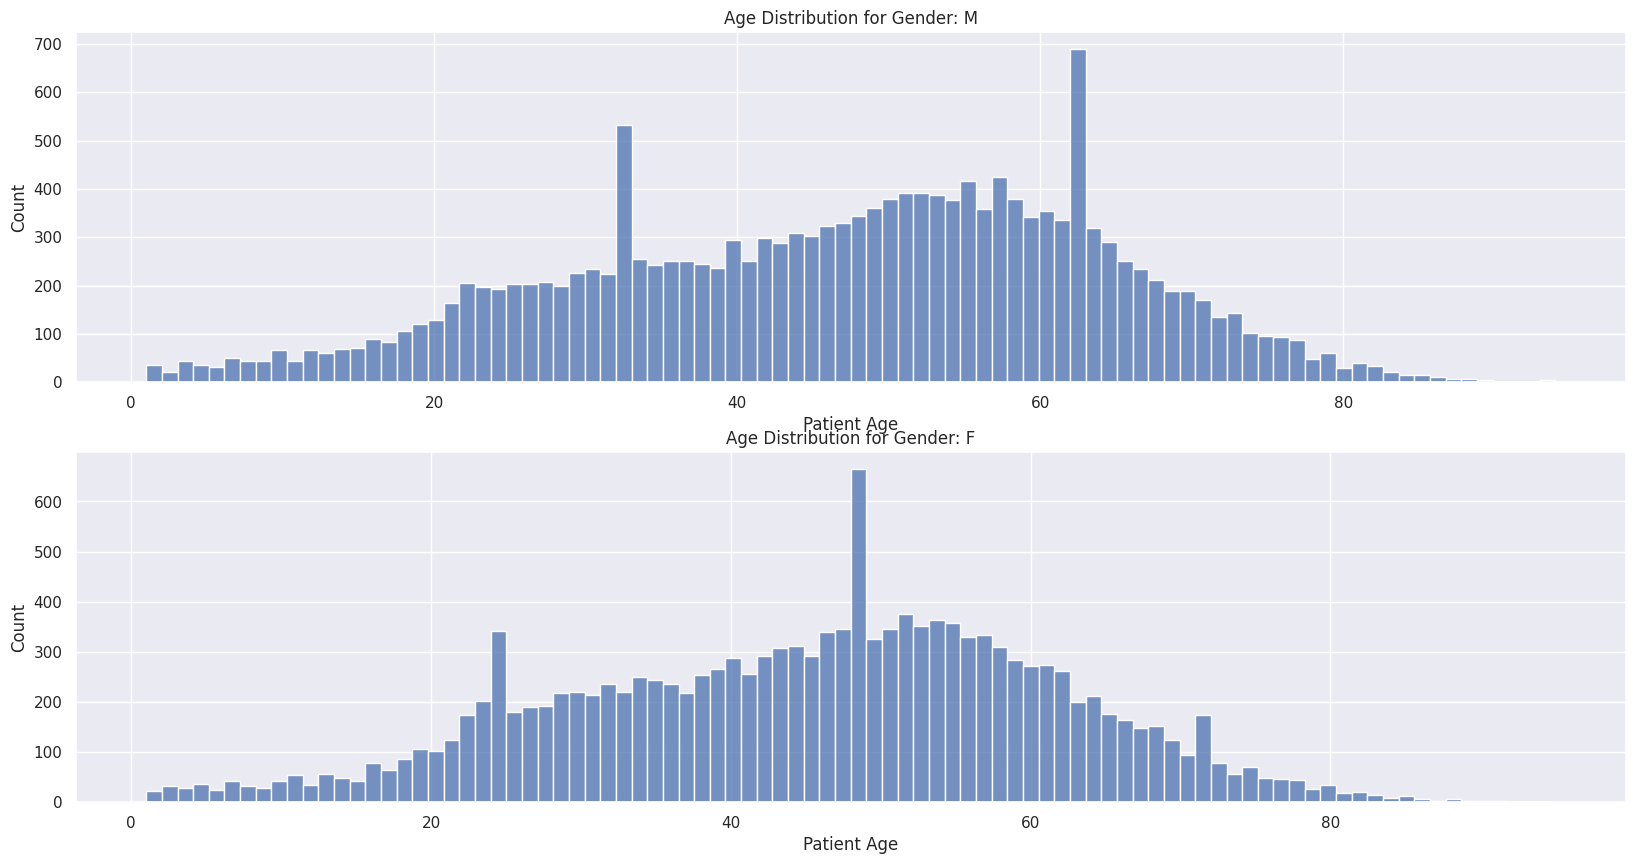

In [84]:
def visualize_age_by_gender(df):
    """
    Visualizes the distribution of age by gender.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.groupby("Patient ID").agg('first')
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))

    for i, val in enumerate(["M", "F"]):
        test1 = test[test['Patient Gender'] == val].reset_index()
        sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)
        axes[i].set_title(f"Age Distribution for Gender: {val}")

    plt.show()

visualize_age_by_gender(df)

**Observation:** 

There are distinct patterns in age distribution between genders, particularly in certain age groups.

### 3.2 Finding Labels and Gender

**Visualization:**

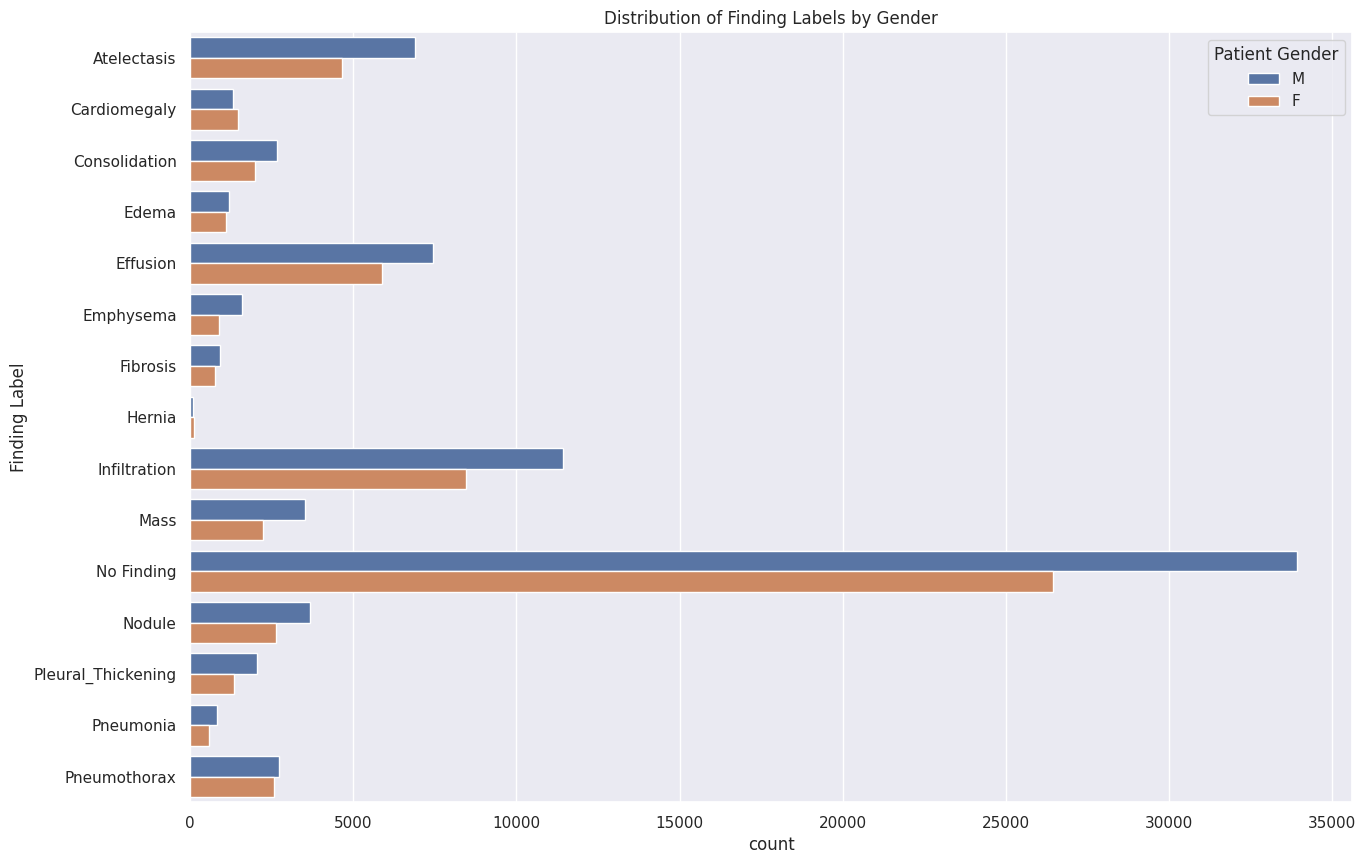

In [85]:
def visualize_labels_by_gender(df):
    """
    Visualizes the distribution of finding labels by gender.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    plot_df = pd.DataFrame()

    for val in ["M", "F"]:
        test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
        test1 = test1.groupby("var1").size().sort_index().reset_index(
            name="count")
        test1["Patient Gender"] = val

        plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    plt.title("Distribution of Finding Labels by Gender")
    ax = sns.barplot(
        y="var1", hue="Patient Gender", x="count", data=plot_df, orient='h')
    plt.ylabel("Finding Label")
    plt.show()

visualize_labels_by_gender(df)

**Observation:**

* While the overall distribution of labels appears similar across genders, there are minor variations in the prevalence of certain conditions. Notably, Cardiomegaly is slightly more common in female patients.

### 3.3 Finding Labels and Age

**Visualization:**

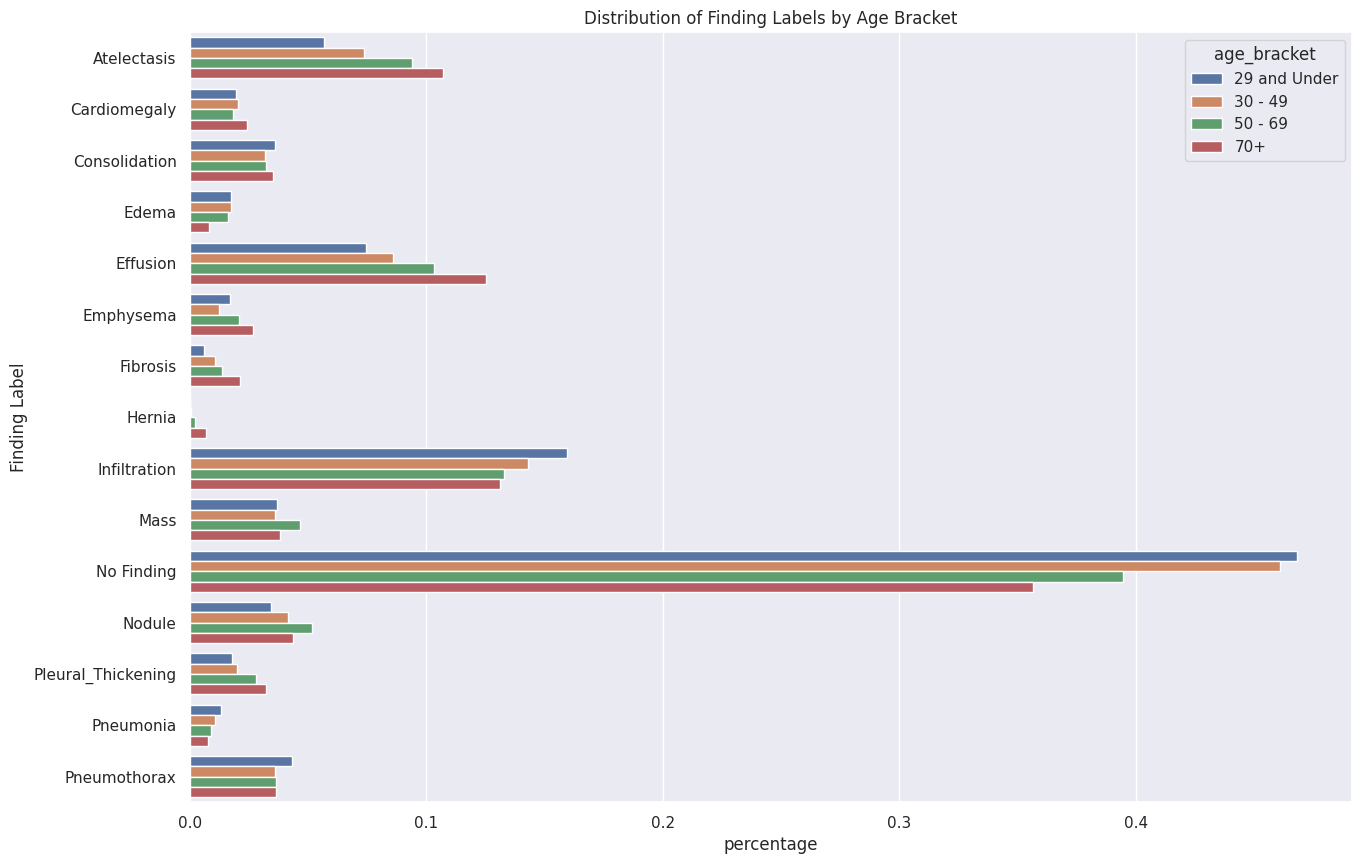

In [86]:
def visualize_labels_by_age(df):
    """
    Visualizes the distribution of finding labels across different age groups.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Patient Age'] <= 29),
        (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
        (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
        (test['Patient Age'] >= 70)
    ]

    choices = ['29 and Under', '30 - 49', '50 - 69', '70+']
    test['age_bracket'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(
        ["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("age_bracket").sum("count").reset_index()

    test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
    test1["percentage"] = test1["count"] / test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Distribution of Finding Labels by Age Bracket")
    ax = sns.barplot(
        y="var1",
        hue="age_bracket",
        x="percentage",
        data=test1,
        orient='h')
    plt.ylabel("Finding Label")
    plt.show()

visualize_labels_by_age(df)

**Observations:**

*  The prevalence of specific findings varies significantly across age groups:
    * Younger patients (under 29) show a higher likelihood of Pneumothorax and Infiltration.
    * Older patients (70+) exhibit a higher prevalence of Pleural_Thickening, Fibrosis, and other conditions, potentially linked to age-related health decline.
    * Middle-aged groups display distinct patterns, such as a higher prevalence of Nodule and Mass in the 50-69 age group.

### 3.4 Finding Labels and Follow-up Number

**Visualization:**

In [31]:
def visualize_labels_by_follow_up(df):
    """
    Visualizes the distribution of finding labels by follow-up number.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Follow-up #'] == 0),  # First visit
        (test['Follow-up #'] >= 1) & (test['Follow-up #'] <= 3),
        (test['Follow-up #'] >= 4) & (test['Follow-up #'] <= 6),
        (test['Follow-up #'] >= 7)
    ]

    choices = ['1st Visit', '2nd-4th Visit', '5th-7th Visit', '8th+ Visit']
    test['visit_group'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(
        ["visit_group", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("visit_group").sum("count").reset_index()

    test1 = test1.merge(test2, on='visit_group', suffixes=('', '_total'))
    test1["percentage"] = test1["count"] / test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Distribution of Finding Labels by Follow-up Visit Group")
    ax = sns.barplot(
        y="var1", hue="visit_group", x="percentage", data=test1, orient='h')
    plt.ylabel("Finding Label")
    plt.show()

visualize_labels_by_follow_up(df)

**Observations:**

* The likelihood of "No Finding" decreases with an increasing number of follow-up visits. This suggests that patients with more visits might have more complex or chronic conditions.
* Certain findings, like Cardiomegaly and Effusion, become more prevalent in later visits, potentially indicating disease progression or the emergence of new issues.
* Interestingly, Nodule appears more frequently in earlier visits, suggesting that it might be easier to detect or that it might be resolved over time.

### 3.5 Single vs. Multi-label Diagnoses

This analysis examines the prevalence of single versus multi-label diagnoses, excluding "No Finding" to focus on disease presence.

**Visualization:**

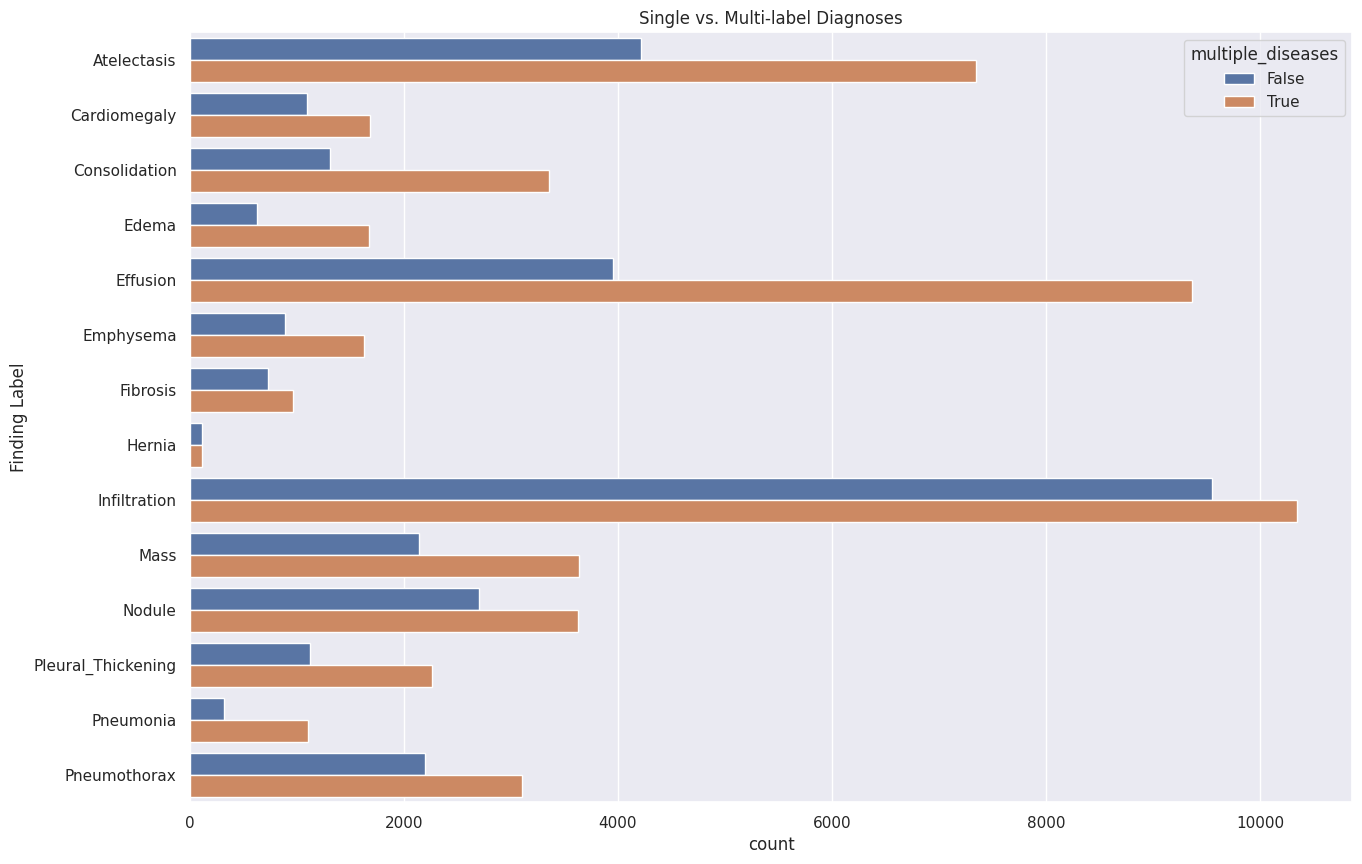

In [89]:
def visualize_single_vs_multi_label(df):
    """
    Visualizes the distribution of single versus multi-label diagnoses.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    test["multiple_diseases"] = test[
        'Finding Labels'].str.match(r'\w+\|\w+')  # Identifying multi-label cases
    test = test[test["Finding Labels"] != "No Finding"]
    test1 = test.groupby(
        ["var1",
         "multiple_diseases"]).size().sort_index().reset_index(name="count")

    plt.figure(figsize=(15, 10))
    plt.title("Single vs. Multi-label Diagnoses")
    ax = sns.barplot(
        y="var1", hue="multiple_diseases", x="count", data=test1, orient='h')
    plt.ylabel("Finding Label")
    plt.show()

visualize_single_vs_multi_label(df)

**Observation:**  

* Most labels are more frequently associated with multi-label diagnoses when "No Finding" is excluded. This highlights the complexity of diagnosing chest-related conditions.

### 3.6 Co-occurrence of Labels

Analyzing the co-occurrence of labels provides insights into potential relationships between different conditions.

**visualization** 

In [33]:
def visualize_label_co_occurrence(df):
    """
    Visualizes the co-occurrence of labels using a network graph.
    
    Args:
      df: The pandas DataFrame containing the image data.
    """
    # Preprocessing: Filtering for images with exactly two labels
    df_filtered = df[df["Finding Labels"].str.count(r'\|') == 1]
    df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
    df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))

    # Getting unique labels
    all_tags = np.unique(np.concatenate(df_filtered['tags'].values))

    # Helper function to add edge weight
    def add_edge_weight(head, tail, graph):
        try:
            graph[head][tail]['weight'] += 1
        except:
            graph.add_edge(head, tail, weight=1)

    # Initializing the graph
    G = nx.Graph()

    # Adding nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # Adding edges (co-occurring tags)
    for _, row in df_filtered.iterrows():
        tags = row['tags']
        add_edge_weight(tags[0], tags[1], G)

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=1.5)  # Adjust k for spacing

    # Calculating total edge weights
    w_sum = sum([data['weight'] for (_, _, data) in G.edges(data=True)])

    # Drawing edges with varying width based on weight
    for (node1, node2, data) in G.edges(data=True):
        width = data["weight"] * len(G.nodes) * 10.0 / w_sum
        nx.draw_networkx_edges(
            G, pos, edgelist=[(node1, node2)], width=width, alpha=0.7)

    nx.draw_networkx_nodes(
        G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

    # Drawing labels without overlap
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    plt.title("Co-occurrence of Labels in Chest X-rays")
    plt.show()

visualize_label_co_occurrence(df)

**Observations:**

*  The network graph effectively illustrates the co-occurrence patterns of labels.
*  Stronger connections (thicker edges) indicate more frequent co-occurrences. 
*  Infiltration, Atelectasis, and Effusion show a high degree of interconnection, suggesting they frequently occur together. This aligns with the previous observations regarding their prevalence in multi-label cases.

## 4. Visualizing Images with Bounding Boxes 

        Image Index Finding Label     Bbox [x           y          w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217  86.779661   

          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0  79.186441         NaN         NaN         NaN  


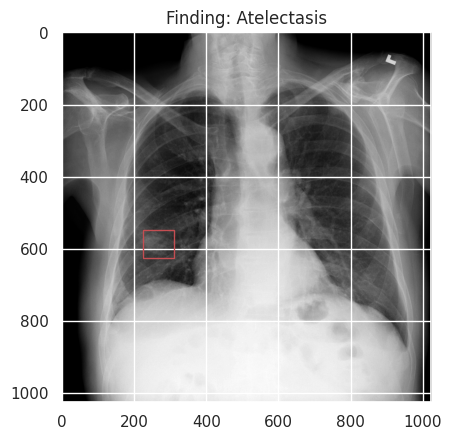

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

df = pd.read_csv("./BBox_List_2017.csv") 

print(df.head(1))
# Load the first image from your dataframe
image_path = "./images_006/images/" + df['Image Index'][0]  # Replace with your actual image directory
image = Image.open(image_path)
x = df['Bbox [x'][0]
y = df['y'][0]
w = df['w'][0]
h = df['h]'][0] 

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray') # Assuming your X-rays are grayscale

# Create a Rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.title(f"Finding: {df['Finding Label'][0]}")
plt.show()

**Observations**
- File BBox_List_2017 contains the bounding boxes that can be used to map to label which in this case is `Atelectasis`

## 5. References 

* Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

* NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

* Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345



## 6. Summary reponse to question 

**1. Variables and Datatypes:**

The dataset contains the following variables:

- **Image Index:** (string) File name of the X-ray image.
- **Finding Labels:** (string) Diagnoses associated with the image, originally a pipe-delimited string.
- **Follow-up #:** (integer) Number of patient visits.
- **Patient ID:** (integer) Unique identifier for each patient.
- **Patient Age:** (integer) Age of the patient.
- **Patient Gender:** (string) 'M' or 'F'.
- **View Position:** (string) 'PA' (Posterior-Anterior) or 'AP' (Anterior-Posterior).
- **OriginalImage[Width:** (integer) Original width of the X-ray image.
- **Height]:** (integer) Original height of the X-ray image.
- **OriginalImagePixelSpacing[x:** (float) Pixel spacing in the x-direction.
- **y]:** (float) Pixel spacing in the y-direction.


**2. Data Issues and Handling:**

- **Missing Data:** An "Unnamed: 11" column was present with no data and was removed.
- **Inconsistent Labels:**  The 'Finding Labels' column contained multiple labels separated by "|", with variations in order. This was addressed by splitting the labels, sorting them alphabetically, and then rejoining them to ensure consistency.
- **Potential Age Errors:** Some records had unrealistic ages (over 120 years), which were removed.
- **Source of Issues:**
    - The missing data column likely resulted from an error in data export or formatting.
    - Inconsistent labels may be attributed to variations in how radiologists record diagnoses.
    - Age errors could be due to typos during data entry.

**3. Variable Relevance and Patterns:**

- **Project Goal:** The goal is to develop a machine learning model to classify chest X-ray images based on the presence of various diseases.
- **Relevance:**  All variables except the original image dimensions and pixel spacing are potentially relevant.
    - 'Finding Labels' is the target variable.
    - 'Image Index' helps link images to patients and track follow-up visits.
    - Patient demographics (age, gender) and 'View Position' may influence disease prevalence.
    - 'Follow-up #' can provide insights into disease progression.

- **Patterns:**
    - Some diseases (Effusion, Infiltration) are more common than others (Hernia).
    - Age and gender show distinct patterns in disease distribution.
    -  Co-occurrence of certain labels suggests potential relationships between diseases. 
    
    
- **Transformations:**
    - The 'Finding Labels' was transformed to ensure consistency.
    - Creating new variables (e.g., age brackets) may improve model performance.

**4. Variable Relationships and Correlations:**

- **Strong Correlations:** The analysis revealed correlations between:
    - Age and gender.
    -  Age and specific diseases.
    - Gender and specific diseases.
    - Follow-up number and disease prevalence.
    -  Co-occurrence of specific diseases (e.g., Infiltration and Atelectasis). 

- **Impact on Model Building:**
    - Correlations need careful consideration to avoid multicollinearity issues.
    - Feature selection techniques can be used to identify the most relevant variables.
    -  Careful handling of multi-label diagnoses is crucial.

